In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#paramaters
pars = {}
pars['a00'] = 1
pars['a01'] = 0
pars['T1'] = 297
pars['a11'] = 1
pars['a10'] = 0
pars['T2'] = 297

pars['gamma0'] = 1
pars['gamma1'] = 1

pars['Kb'] = 1.380649*10**-23

pars['noise0'] = np.sqrt(2*pars['gamma0']*pars['Kb']*pars['T1'])
pars['noise1'] = np.sqrt(2*pars['gamma1']*pars['Kb']*pars['T2'])

pars['delta_t'] = 0.01


In [3]:
def analytical_soln_acf_generic(omega_list, pars):

    autocorr_list = []
    for omega in omega_list:
        numerator = ( pars['a11']**2 * pars['noise0']**2 ) \
        + ( pars['a01']**2 * pars['noise1']**2 ) \
        + ( (omega**2) * (pars['gamma1']**2) * (pars['noise0']**2) )

        denominator = ( -2*pars['a11']*pars['a00']*pars['a10']*pars['a01'] ) \
        + ( (omega**2) * (pars['gamma0']**2) * (pars['a11']**2) ) \
        + ( ( (pars['a10']*pars['a01']) + (pars['gamma0']*pars['gamma1']* (omega**2) ) )**2) \
        + ( (pars['a00']**2) * ( (pars['a11']**2) + (omega**2) * (pars['gamma1']**2) ) )

        autocorr = numerator/denominator
        autocorr_list.append(autocorr/(1e-6))
    return autocorr_list

In [4]:
def euler_one_traj(n_time, pars):   
    #initial condition
    x1 = 0
    x2 = 0
    x1_traj = []
    x2_traj = []
    
    #performing 1 traj with n_time number of data points
    for i in range(n_time):
        #generate delta_B
        s1 = np.random.normal(0, np.sqrt(pars['delta_t']) )
        s2 = np.random.normal(0, np.sqrt(pars['delta_t']) )
        #solve for x1, x2
        x1_new = x1 - (pars['a00']/pars['gamma0'])*x1*pars['delta_t'] - \
        (pars['a01']/pars['gamma0'])*x2*pars['delta_t'] + \
        np.sqrt((2*pars['Kb']*pars['T1'])/pars['gamma0'])*s1
                 
        x2_new = x2 - (pars['a11']/pars['gamma1'])*x2*pars['delta_t'] - \
        (pars['a10']/pars['gamma1'])*x1*pars['delta_t'] + \
        np.sqrt((2*pars['Kb']*pars['T2'])/pars['gamma1'])*s2
                
        x1 = x1_new
        x2 = x2_new
        
        x1_traj.append(x1)
        x2_traj.append(x2)
    return x1_traj, x2_traj

In [5]:
def euler_n_traj(max_time, pars):
    min_time = 0
    n_time = int((max_time - min_time)/pars['delta_t'] + 1) #n_time = num of evenly spaced samples (ex. 1001 points)
    time = np.linspace(min_time, max_time, n_time) #time(ex. 0 (min time), 0.01, 0.02, ..., 10 (max time)) with n_time no. of data points
    
    x_traj_list = []
    y_traj_list = []
    for i in range(pars['n_realizations']):
        x_traj, y_traj = euler_one_traj(n_time, pars)
        x_traj_list.append(x_traj)
        y_traj_list.append(y_traj)
        
    return x_traj_list, y_traj_list, time

In [6]:
#plot trajectories with t = 10s
pars['n_realizations'] = 10
x_traj_list, y_traj_list, time = euler_n_traj(500, pars)

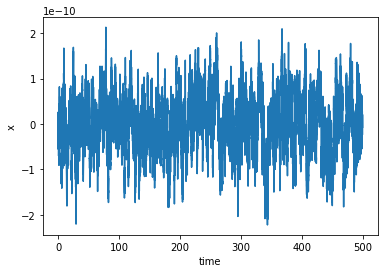

In [7]:
#Plot a sample trajectory
plt.plot(time, x_traj_list[0])
plt.xlabel('time')
plt.ylabel('x')
plt.show()

Calculate autocorrelation

In [8]:
def autocorr(x):
    tau = np.arange(1,500)
    
    corr_list = []
    for t in tau:
        xtau = np.roll(x, -t)
        
        product_list = []
        for x_value, xtau_value in zip(x, xtau):
            product = x_value*xtau_value
            product_list.append(product)
            
        corr = np.array(product_list[:-t]).mean()
        corr_list.append(corr)
    return corr_list

In [9]:
def ave_autocorr_traj(trajectory):
    autocorr_list = []
    for traj in trajectory:
        autocorr_traj = autocorr(traj)
        autocorr_list.append(autocorr_traj)
        
    matrix = np.array((autocorr_list))
    mean_per_column = matrix.mean(axis=0)
    
    return mean_per_column

In [10]:
%%time
xtraj = ave_autocorr_traj(x_traj_list)

Wall time: 1min 13s


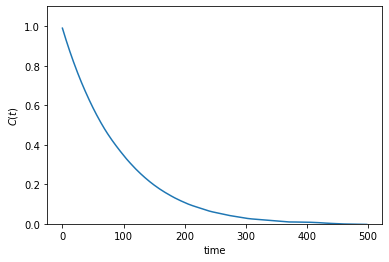

In [11]:
normalization = np.mean(np.array(x_traj_list)*np.array(x_traj_list))

plt.plot(xtraj/normalization)
plt.ylim(0,1.1)
plt.xlabel('time')
plt.ylabel('$C(t)$')
plt.show()

Transform $C(t)$ to $C(\omega)$

In [12]:
c_omega = np.fft.fft(xtraj/normalization)
tt = np.arange(0,len(c_omega))
freq = np.fft.fftfreq(tt.shape[-1])

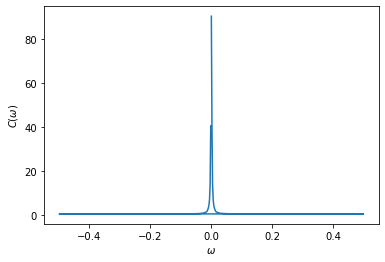

In [13]:
plt.plot(freq, c_omega.real)
plt.xlabel('$\omega$')
plt.ylabel('$C(\omega)$')
plt.show()

Calculate autocorrelation from analytical solution

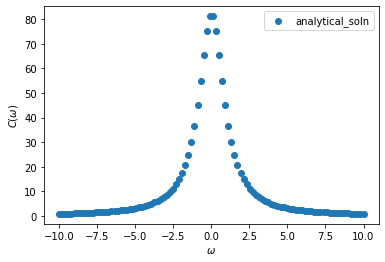

In [14]:
omega_list = np.linspace(-10, 10, 100)
generic_soln = analytical_soln_acf_generic(omega_list, pars)
plt.scatter(omega_list, np.array(generic_soln)/(1e-16), label='analytical_soln')
plt.xlabel('$\omega$')
plt.ylabel('$C(\omega)$')
plt.legend()
plt.show()

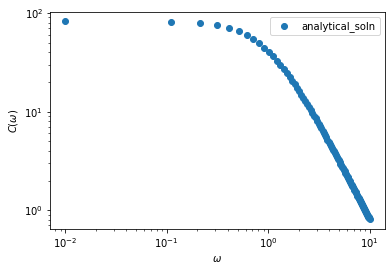

In [15]:
plt.xscale('log')
plt.yscale('log')
omega_list = np.linspace(0.01, 10, 100)
generic_soln = analytical_soln_acf_generic(omega_list, pars)
plt.scatter(omega_list, np.array(generic_soln)/(1e-16), label='analytical_soln')
plt.xlabel('$\omega$')
plt.ylabel('$C(\omega)$')
plt.legend()
plt.show()

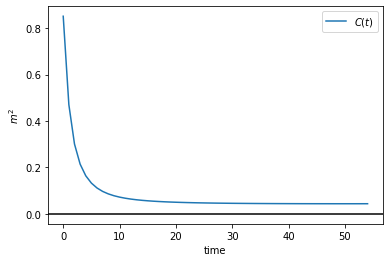

In [16]:
omega_new_list = np.linspace(10, 100, 100)
paper_soln_logspace = analytical_soln_acf_generic(omega_new_list, pars)
inverse_fourier = np.fft.ifft(paper_soln_logspace)
plt.plot(inverse_fourier.real[:55]/(1e-17), label='$C(t)$')
plt.axhline(0*10**-7, color='black')
plt.legend()
plt.xlabel('time')
plt.ylabel('$m^2$')

plt.show()